# OSG Statistics by Elevation
i.e. How does the p95 wind change with elevation throughout a day

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_data.grid_manager import pluck_point_new
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_data.grid_manager import pluck_point_new

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b\n%d')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

In [2]:
# Load HRRR Lat/Lon/Elevation data
H = get_hrrr_variable(datetime(2017, 1, 1), variable='HGT:surface')
lat = H['lat']
lon = H['lon']

./temp_2017010100_f00_HGT.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 46:30408372:d=2017010100:HGT:surface:anl

range: 30408372 32644720


## Domain Center

In [140]:
name = 'BRIANHEAD'
lat = 37.718
lon = -112.837

cut_v, cut_h = pluck_point_new(lat, lon, H['lat'], H['lon'])

size = 15

# Create Map object for test plotting
m = Basemap(resolution='i', projection='cyl',\
            llcrnrlon=H['lon'][cut_v-size,cut_h-size][0], llcrnrlat=H['lat'][cut_v-size,cut_h-size][0],\
            urcrnrlon=H['lon'][cut_v+size,cut_h+size][0], urcrnrlat=H['lat'][cut_v+size,cut_h+size][0],)

In [141]:
# D is for the Domain limits.
#   Take the center point and go back/forward/up/down x grids to create the bounding box limits.
D = np.meshgrid(range(cut_v[0]-size,cut_v[0]+size), range(cut_h[0]-size,cut_h[0]+size))
# D[0] is the x positions, D[1] is the y positions

In [142]:
# Domain LAT, LON, HGT
LATS = H['lat'][D]
LONS = H['lon'][D]
HGTS = H['value'][D]

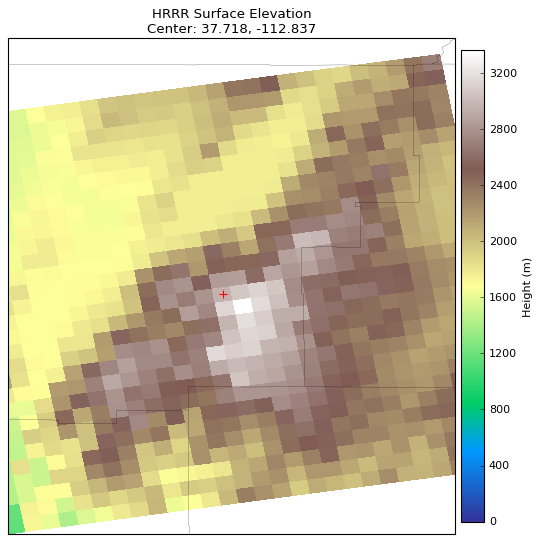

In [143]:
m.drawcoastlines()
m.drawstates()
m.drawcounties()
m.pcolormesh(LONS, LATS, HGTS,
             cmap='terrain',
             vmin=0,
             latlon=True)
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=.95)
cb.set_label('Height (m)')
plt.scatter(lon, lat, marker="+", c='r', s=50)
plt.title('HRRR Surface Elevation\nCenter: %s, %s' % (lat, lon))

Create height bins for the data

In [179]:
bin_interval = 200
if HGTS.min() > 0:
    HGT_bins = np.arange(int(HGTS.min()/100)*100, HGTS.max(), bin_interval)
    HGT_bins = np.append(HGT_bins, HGTS.max())
    HGT_bins[0] = HGTS.min()
else:
    HGT_bins = np.arange(0, HGTS.max(), bin_interval)
    HGT_bins = np.append(HGT_bins, HGTS.max())
    HGT_bins = np.append(H['value'].min(), HGT_bins)
    HGT_bins[1] = 0.100

for i in HGT_bins:
    print i

1156.58898926
1300.0
1500.0
1700.0
1900.0
2100.0
2300.0
2500.0
2700.0
2900.0
3100.0
3300.0
3361.15161133


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

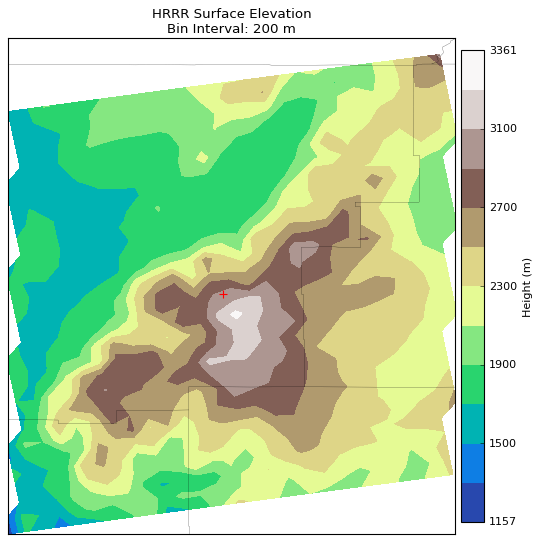

In [180]:
# Plot the bins by contourf
m.contourf(LONS, LATS, HGTS,
           latlon=True,
           levels=HGT_bins,
           cmap='terrain')
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=.95)
cb.set_label('Height (m)')
plt.title('HRRR Surface Elevation\nBin Interval: %s m' % bin_interval)
plt.scatter(lon, lat, marker="+", c='r', s=50)
m.drawcoastlines()
m.drawstates()
m.drawcounties()
plt.savefig('./figs/Domain_%s_p95ofp95' % (name))

In [181]:
storage_p95 = np.zeros([len(HGT_bins), 24])
storage_samples = np.zeros([len(HGT_bins), 24])
print np.shape(storage_p95)

(13, 24)


Load the percentile data

In [198]:
## month = 8
day = 15

STAT = 'p95'

var = 'GUST:surface'
variable = var.replace(':', '_').replace(' ', '_')
varSAVE = var.replace(':', '').replace(' ', '')


# ==============================================================
if var == 'GUST:surface':
    cmap = 'Reds'
    cblabel = r'Surface Gust (m s$\mathregular{^{-1}}$)'
    vmax = 23
    vmin = 0
if var == 'UVGRD:10 m':
    cmap = 'Blues'
    cblabel = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
    vmax = 23
    vmin = 0
elif var == 'UVGRD:80 m':
    cmap = 'BuPu'
    cblabel = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
    vmax = 25
    vmin = 0
elif var == 'TMP:2 m':
    cmap = 'Spectral_r'
    cblabel = '2 m Temperture (C)'
    vmax = 50
    vmin = -10
elif var == 'DPT:2 m':
    cmap = 'BrBG'
    cblabel = '2 m Dew Point (C)'
elif var == 'DPT:2 m':
    cmap = 'BrBG'
    cblabel = '2 m Dew Point (C)'
    vmax = 30
    vmin = -10
elif var == 'REFC:entire':
    cmap = 'gist_ncar'
    cblabel = 'Composite Reflectivity (dBZ)'
    vmax = 40
    vmin = -10
# ============================================================== 

# open the file for each hour
for hour in range(0, 24):
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
    FILE = DIR + 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
                  (variable, month, day, hour)

    with h5py.File(FILE, 'r') as f:
        if var == 'TMP:2 m' or var == 'DPT:2 m':
            p95 = f[STAT][:][D] - 273.15
        else:
            p95 = f[STAT][:][D]
    
    # Loop through each elevation section
    for i in range(len(HGT_bins)-1):
        pixels_in_bin = np.logical_and(HGTS > HGT_bins[i], HGTS <= HGT_bins[i+1])

        p95_bin = p95
        p95_bin = np.ma.array(p95_bin)
        p95_bin[pixels_in_bin == False] = np.ma.masked

        if np.sum(pixels_in_bin)>0:
            area_per = np.percentile(p95[pixels_in_bin], [95])
        else:
            area_per = [None]
            
        
        storage_p95[i, hour] = area_per[0]
        storage_samples[i, hour] = np.sum(pixels_in_bin)

        if hour == -1:
            plt.figure(i)
            m.drawcoastlines()
            m.drawstates()
            m.drawcoastlines()
            m.pcolormesh(LONS, LATS, p95_bin,
                         cmap='viridis',
                         vmax=20, vmin=0,
                         latlon=True)
            plt.title('Elevation Bin:%.2f-%.2f\nSamples:%s p95=%s' % (HGT_bins[i], HGT_bins[i+1], np.sum(pixels_in_bin), area_per[0]))
            plt.savefig('./figs/elev_bin_%02d' % (i))

(13, 24)


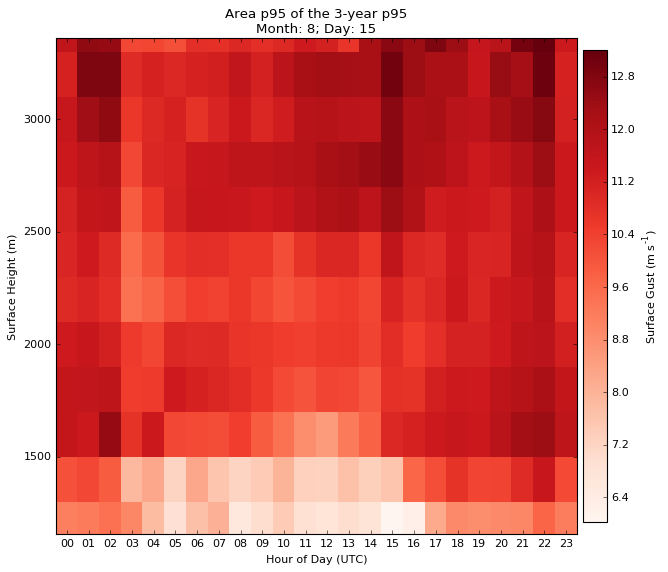

In [199]:
print np.shape(storage_p95)
plt.title('Area p95 of the 3-year p95\nMonth: %s; Day: %02d' % (month, day))
plt.pcolormesh(range(0,25), HGT_bins, storage_p95,
               cmap=cmap,
               #vmax=vmax,
               #vmin=vmin
              )
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=.95)
cb.set_label(cblabel)

plt.ylim([HGT_bins[0], HGT_bins[-1]])
plt.ylabel('Surface Height (m)')
plt.xlabel('Hour of Day (UTC)')
plt.xlim([0, 24])
t = plt.xticks(np.arange(0.5,24,1), ['%02d' % h for h in range(0,24)])

plt.savefig('./figs/%s_HRRR_%s_p95ofp95_m%02d_d%02d_HOURS' % (name, varSAVE, month, day))

## 

#### Plot number of samples in each bin

[   1.    7.  143.  152.  120.  150.  147.   88.   58.   23.    9.    1.
    0.]


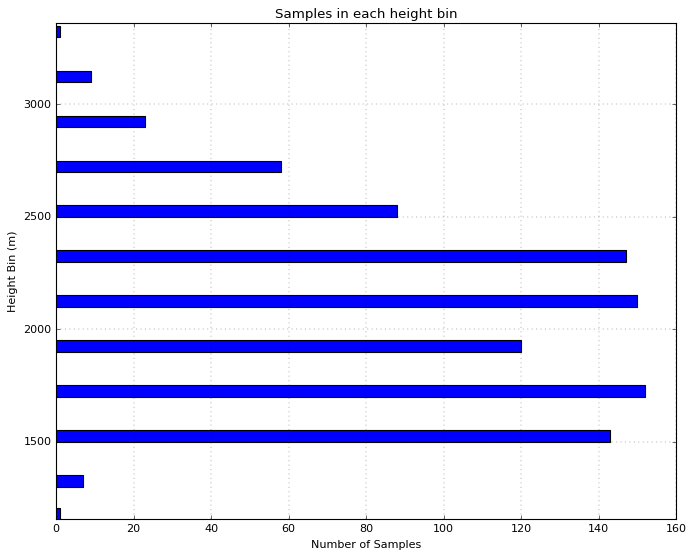

In [185]:
plt.title('Samples in each height bin')
t = plt.barh(HGT_bins, storage_samples[:,0], height=50 )
plt.ylim([HGT_bins[0], HGT_bins[-1]])
plt.xlabel('Number of Samples')
plt.ylabel('Height Bin (m)')
plt.grid()
plt.savefig('./figs/%s_HRRR_samples' % name)

#for i, v in enumerate(storage_samples[:,0]):
#    plt.text(v + 3, HGT_bins[i], str(v), color='blue', fontweight='bold')

print storage_samples[:,0]